In [31]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem
import time

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import scienceplots
import cmasher as cmr
plt.style.use('science')
import jax.random as random 
from matplotlib.patches import Ellipse
import jax.scipy.stats as statsjax

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

import JaxStreams_diffrax as JaxStreams

In [32]:
bar_pattern = ((-60.0*u.km/u.s)/u.kpc).to(1.0/u.Myr).value #in rad / Myr

params_global_potential = {'m_disk':5.0e10, 'a_disk': 3.0, 'b_disk': 0.25, 'm_NFW': 1.0e12,
                          'r_s_NFW': 15.0, 'bar_m':1.0e10, 'bar_a':1.0, 'bar_b':1.0, 'bar_c':0.5, 'bar_Omega': bar_pattern}

pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                       b=params_global_potential['b_disk'],units=usys)
pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

pot_Bar = JaxStreams.BarPotential(m=params_global_potential['bar_m'], a=params_global_potential['bar_a'],
                                 b=params_global_potential['bar_b'], c=params_global_potential['bar_c'],Omega=params_global_potential['bar_Omega'],units=usys)

## Combine potentials
potential_list = [pot_disk,pot_NFW,pot_Bar]
pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)


In [33]:
pal5_c = coord.SkyCoord(ra=229.018*u.degree, dec=-0.124*u.degree,
                         distance=22.9*u.kpc,
                         pm_ra_cosdec=-2.296*u.mas/u.yr,
                         pm_dec=-2.257*u.mas/u.yr,
                         radial_velocity=-58.7*u.km/u.s)
rep = pal5_c.transform_to(coord.Galactocentric).data
pal5_w0 = gd.PhaseSpacePosition(rep)

wf = jnp.hstack([pal5_w0.pos.xyz.T.value,pal5_w0.vel.d_xyz.to(u.kpc/u.Myr).value])

In [34]:
t0 = 0.
dt = .5
n_steps = 4_000 #this is really how many particles you will have in one arm of the stream
ts = jnp.linspace(0,4000.,n_steps)###jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
t_back = -ts
w_back = pot.orbit_integrator_run(wf,t0=0.0,t1=t_back.min(),ts=None)[0]
ts_forward = jnp.linspace(t_back.min(),0,len(ts))
w_forward = pot.orbit_integrator_run(w_back,t0=t_back.min(),t1=0.0,ts=None)[0]

In [35]:
ts_forward

Array([-4.00000000e+03, -3.99899975e+03, -3.99799950e+03, ...,
       -2.00050013e+00, -1.00025006e+00,  0.00000000e+00], dtype=float64)

In [36]:
print('PERCENT error in position:',100*(w_forward-wf)/wf)

PERCENT error in position: [ 0.00812824  0.64895071  0.00157637 -0.05170073 -0.00079924 -0.30019444]


In [37]:
## Now generate a mock stream along the above orbit
M_sat = 2.5e4 #progenitor mass
start = time.time()
lead_arm, trail_arm = pot.gen_stream_final(ts_forward, w_back, M_sat,)
end = time.time()
print(end-start)

13.093166828155518


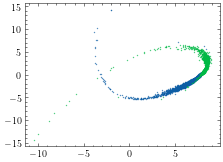

In [38]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.1,rasterized=True)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.1,rasterized=True)
stream = jnp.vstack([lead_arm,trail_arm])

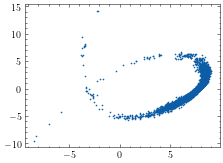

In [39]:
kde = statsjax.gaussian_kde(stream[:,:3].T,bw_method=jnp.sqrt(.001**2 + .1**2))
key = jax.random.PRNGKey(3)
samps = kde.resample(key,[len(stream)]).T
plt.scatter(samps[:,0],samps[:,1],s=.4)

In [40]:
@jax.jit
def gen_observed_stream(params,ts,w0,M_sat):
    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                               b=params['b_disk'],units=usys)
    pot_NFW = JaxStreams.NFWPotential(m=params['m_NFW'], r_s=params['r_s_NFW'],units=usys)
    
    pot_Bar = JaxStreams.BarPotential(m=params['bar_m'], a=params['bar_a'],
                                 b=params['bar_b'], c=params['bar_c'],Omega=params['bar_Omega'],units=usys)

    ## Combine potentials
    potential_list = [pot_disk,pot_NFW,pot_Bar]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
    
    ## Generate a stream. This will be the "observed" stream, i.e., the DATA
    lead_arm, trail_arm = pot.gen_stream_final(ts, w0, M_sat,) 
    
    return lead_arm, trail_arm #jnp.sum(lead_arm_obs**2 + trail_arm_obs**2)
@jax.jit
def compare_streams(params,ts,w0,M_sat):
    ## first generate data stream (no grad tracking)
    lead_arm, trail_arm = gen_observed_stream(params,ts,w0,M_sat)
    lead_arm_obs, trail_arm_obs = jax.lax.stop_gradient(lead_arm), jax.lax.stop_gradient(trail_arm)
    
    stream_obs = jnp.vstack([lead_arm_obs,trail_arm_obs])
    stream = jnp.vstack([lead_arm,trail_arm])
    
    #kde = statsjax.gaussian_kde(stream_obs[:,:3].T,bw_method=jnp.sqrt(.001**2 + .1**2))
    #log_like = jnp.sum(kde.logpdf(stream[:,:3].T)) 
    return -jnp.sum(jnp.square(stream-stream_obs))#log_like#-jnp.sum( (lead_arm-lead_arm_obs)**2 + (trail_arm-trail_arm_obs)**2 )
    
    
@jax.jit
def first_deriv_func(params,ts,w0,M_sat):
    return jax.jacfwd(compare_streams,argnums=0)(params,ts,w0,M_sat)

    
@jax.jit
def second_deriv_func(params,ts,w0,M_sat):
    return jax.jacfwd(first_deriv_func)(params,ts,w0,M_sat)

In [41]:
compare_streams(params_global_potential,ts_forward,w_back,M_sat)

Array(-0., dtype=float64)

In [42]:
first_deriv = first_deriv_func(params_global_potential,ts_forward,w_back,M_sat)

In [43]:
first_deriv

{'a_disk': Array(-0., dtype=float64),
 'b_disk': Array(-0., dtype=float64),
 'bar_Omega': Array(-0., dtype=float64),
 'bar_a': Array(-0., dtype=float64),
 'bar_b': Array(-0., dtype=float64),
 'bar_c': Array(-0., dtype=float64),
 'bar_m': Array(-0., dtype=float64),
 'm_NFW': Array(-0., dtype=float64),
 'm_disk': Array(-0., dtype=float64),
 'r_s_NFW': Array(-0., dtype=float64)}

In [27]:
###params_global_potential['a_disk'] = 14.0
###params_global_potential

In [ ]:
s = time.time()
second_deriv = second_deriv_func(params_global_potential,ts_forward,w_back,M_sat)
e = time.time()
print(e-s)

In [30]:
second_deriv

{'a_disk': {'a_disk': Array(-3029.94913587, dtype=float64),
  'b_disk': Array(-298.45281684, dtype=float64),
  'bar_Omega': Array(703263.92155581, dtype=float64),
  'bar_a': Array(-659.85490716, dtype=float64),
  'bar_b': Array(-4736.47612287, dtype=float64),
  'bar_c': Array(-724.55080498, dtype=float64),
  'bar_m': Array(3.14989768e-06, dtype=float64),
  'm_NFW': Array(4.84871163e-07, dtype=float64),
  'm_disk': Array(7.28304136e-07, dtype=float64),
  'r_s_NFW': Array(-42780.35516641, dtype=float64)},
 'b_disk': {'a_disk': Array(-298.45281684, dtype=float64),
  'b_disk': Array(-29.62533055, dtype=float64),
  'bar_Omega': Array(68927.81470011, dtype=float64),
  'bar_a': Array(-64.84152151, dtype=float64),
  'bar_b': Array(-467.36814539, dtype=float64),
  'bar_c': Array(-71.90133027, dtype=float64),
  'bar_m': Array(3.10570425e-07, dtype=float64),
  'm_NFW': Array(4.76791881e-08, dtype=float64),
  'm_disk': Array(7.17690729e-08, dtype=float64),
  'r_s_NFW': Array(-4208.49060255, dtype=

In [26]:
second_deriv

{'a_disk': {'a_disk': Array(-17724.24106433, dtype=float64),
  'b_disk': Array(-2477.25436233, dtype=float64),
  'bar_Omega': Array(2483334.5678001, dtype=float64),
  'bar_a': Array(1442.86764641, dtype=float64),
  'bar_b': Array(-7304.4447894, dtype=float64),
  'bar_c': Array(-1655.24154756, dtype=float64),
  'bar_m': Array(3.65679369e-06, dtype=float64),
  'm_NFW': Array(3.63601213e-07, dtype=float64),
  'm_disk': Array(2.08379471e-06, dtype=float64),
  'r_s_NFW': Array(-35030.7216627, dtype=float64)},
 'b_disk': {'a_disk': Array(-2477.25436233, dtype=float64),
  'b_disk': Array(-377.38437309, dtype=float64),
  'bar_Omega': Array(342189.94552824, dtype=float64),
  'bar_a': Array(185.96090977, dtype=float64),
  'bar_b': Array(-1022.61723488, dtype=float64),
  'bar_c': Array(-243.16347456, dtype=float64),
  'bar_m': Array(5.04098662e-07, dtype=float64),
  'm_NFW': Array(4.64655382e-08, dtype=float64),
  'm_disk': Array(2.84201031e-07, dtype=float64),
  'r_s_NFW': Array(-4544.50088627, 

In [27]:
start = time.time()
second_deriv = jax.jacfwd(first_deriv_func)(params_global_potential,ts_forward,w_back,M_sat)
end = time.time()
print(end-start)

In [29]:
#second_deriv

In [30]:
start = time.time()
second_deriv = jax.jacrev(first_deriv_func)(params_global_potential,ts_forward,w_back,M_sat)
end = time.time()
print(end-start)

RuntimeError: Cannot reverse-mode autodifferentiate when using `diffeqsolve(..., max_steps=None, adjoint=RecursiveCheckpointAdjoint(checkpoints=None))`. This is because JAX needs to know how much memory to allocate for saving the forward pass. You should either put a bound on the maximum number of steps, or explicitly specify how many checkpoints to use.

In [14]:
start = time.time()
first_deriv = jax.jacfwd(compare_streams,argnums=0)(params_global_potential,ts_forward,w_back,M_sat)
end = time.time()
print(end-start)

23.090246200561523


In [50]:
first_deriv

{'a_disk': Array(-0., dtype=float64),
 'b_disk': Array(-0., dtype=float64),
 'bar_Omega': Array(-0., dtype=float64),
 'bar_a': Array(-0., dtype=float64),
 'bar_b': Array(-0., dtype=float64),
 'bar_c': Array(-0., dtype=float64),
 'bar_m': Array(-0., dtype=float64),
 'm_NFW': Array(-0., dtype=float64),
 'm_disk': Array(-0., dtype=float64),
 'r_s_NFW': Array(-0., dtype=float64)}

In [63]:
start = time.time()
second_deriv = jax.jacfwd(jax.jacfwd(compare_streams,argnums=0))(params_global_potential,ts_forward,w_back,M_sat)
end = time.time()
print(end-start)

1929.748643875122


In [66]:
#####np.save('second_deriv_dict',second_deriv)

In [64]:
second_deriv['bar_b']

{'a_disk': Array(-21073694.68893389, dtype=float64),
 'b_disk': Array(-2827903.44343206, dtype=float64),
 'bar_Omega': Array(-1.86418352e+08, dtype=float64),
 'bar_a': Array(-476275.21654258, dtype=float64),
 'bar_b': Array(-6428367.47136351, dtype=float64),
 'bar_c': Array(-1350812.18178627, dtype=float64),
 'bar_m': Array(0.00327751, dtype=float64),
 'm_NFW': Array(0.00032497, dtype=float64),
 'm_disk': Array(0.00226223, dtype=float64),
 'r_s_NFW': Array(-31568017.74693523, dtype=float64)}

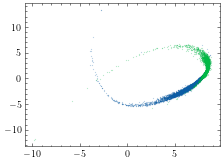

In [67]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.01,rasterized=True)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.01,rasterized=True)

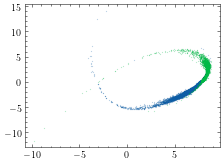

In [74]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.01,rasterized=True)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.01,rasterized=True)

In [4]:
t0 = 0.
dt = 0.5
n_steps = 8_000#*1000
ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
out = pot.orbit_integrator_run(wf,t0,jnp.max(ts),ts)
#output = JaxStreams.orbit_integrator_run(w0=wf,t0=t0,t1=jnp.max(ts),ts=ts,potential_obj=pot)

In [5]:
Msat = 1.0e4
pos_close_arr, pos_far_arr, vel_close_arr, vel_far_arr = pot.gen_stream_ics(ts,wf,Msat)

In [8]:
lead,trail = pot.gen_stream_vmapped(ts,wf,Msat)

In [7]:
lead,trail = pot.gen_stream_final(ts,wf,Msat)

In [11]:
dir(pot.gen_stream_final)

['__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__wrapped__',
 '_fun',
 'lower']

In [8]:
lead.shape

(8000, 6)

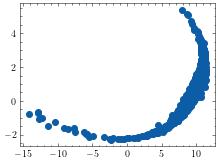

In [9]:
plt.scatter(lead[:,0],lead[:,1])

In [38]:
t0 = 0.
dt = 0.25
n_steps = 16_000#*1000
ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
ws_jax_backward = JaxStreams.leapfrog_run(wf, -ts, pot.gradient)

ts = jnp.flip(-ts)
ws_forward_ag = JaxStreams.leapfrog_run(ws_jax_backward[-1,:],ts,pot.gradient)

w_init = ws_jax_backward[-1,:]
wf, ws_forward_ag[-1,:]

(Array([ 7.86771862e+00,  2.32269577e-01,  1.64124381e+01, -4.32708085e-02,
        -1.06060675e-01, -1.57716157e-02], dtype=float64),
 Array([ 7.95668113e+00,  4.40895726e-01,  1.64494958e+01, -4.03870510e-02,
        -1.05849603e-01, -9.50204493e-03], dtype=float64))

In [39]:
## Now generate a mock stream along the above orbit
M_sat = 2.5e4 #progenitor mass
start = time.time()
lead_arm, trail_arm = pot.gen_stream_final(ts, w_init, M_sat,)
end = time.time()
print(end-start)

39.72716283798218


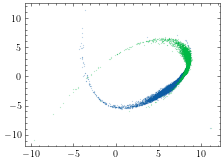

In [40]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.01,rasterized=True)
plt.scatter(trail_arm[:,0],trail_arm[:,1],s=0.01,rasterized=True)

In [54]:
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt,PIDController,DiscreteTerminatingEvent
def f(t, y, args):
    return -y

term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2., 3.])
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)

In [45]:
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)

In [66]:
@jax.jit
def velocity_acceleration(t,xv,args):
    x, v = xv[:3], xv[3:]
    acceleration = -pot.gradient(x,t)
    return jnp.hstack([v,acceleration])

    

In [87]:
ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
ts

Array([0.00000e+00, 2.50000e-01, 5.00000e-01, ..., 3.99950e+03,
       3.99975e+03, 4.00000e+03], dtype=float64)

In [96]:
term = ODETerm(velocity_acceleration)
solver = Dopri5()
saveat = SaveAt(t0=True, t1=True, ts=None, dense=False)
rtol: float = 1e-7
atol: float = 1e-7
stepsize_controller = PIDController(rtol=rtol, atol=atol)
max_steps: int = 16**3
t0 = 0.0
t1 = 4000.
dense = False
y0= w_init


In [97]:
solution = diffeqsolve(
        terms=term,
        solver=solver,
        t0=t0,
        t1=t1,
        y0=y0,
        dt0=None,
        saveat=saveat,
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=None,
        max_steps=(max_steps if dense else None),
    )

In [100]:
solution.ys.shape

(2, 6)

In [78]:
solution.ys[0]

Array([ 7.86744457,  0.23100803, 16.41273869, -0.04367866, -0.10606968,
       -0.01664439], dtype=float64, weak_type=True)

In [71]:
help(solution)

Help on Solution in module diffrax.solution object:

class Solution(diffrax.path.AbstractPath)
 |  Solution(*args, **kwargs)
 |  
 |  The solution to a differential equation.
 |  
 |  **Attributes:**
 |  
 |  - `t0`: The start of the interval that the differential equation was solved over.
 |  - `t1`: The end of the interval that the differential equation was solved over.
 |  - `ts`: Some ordered collection of times. Might be `None` if no values were saved.
 |      (i.e. just `diffeqsolve(..., saveat=SaveAt(dense=True))` is used.)
 |  - `ys`: The value of the solution at each of the times in `ts`. Might `None` if no
 |      values were saved.
 |  - `stats`: Statistics for the solve (number of steps etc.).
 |  - `result`: Integer specifying the success or cause of failure of the solve. A
 |      value of `0` corresponds to a successful solve. Any other value is a failure.
 |      A human-readable message can be obtained by looking up messages via
 |      `diffrax.RESULTS[<integer>]`.
 |